In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
import sklearn.metrics as metrics

In [5]:
data = pd.read_csv("/content/drive/MyDrive/암마커추출/data.csv", sep=',')
data

,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932,Cancer_info
0,0.0,10.0113,11.2820,49.5994,848.9397,0.0,345.2308,1.0472,0.0000,0.0,...,292.5212,959.2460,0.6981,1088.0531,2837.9440,871.2802,575.2683,6.6323,0.0000,0
1,0.0,7.1957,12.4436,90.5117,924.0158,0.0,145.2025,1.6098,0.0000,0.0,...,493.5597,1179.3275,20.2833,787.5061,2351.2500,1138.1170,690.2752,179.9738,0.0000,0
2,0.0,7.2453,6.0184,49.5366,1140.6781,0.0,51.7284,0.0000,0.0000,0.0,...,365.4149,843.9028,26.5274,475.1720,5437.4534,1170.5214,532.8691,6.3003,0.0000,0
3,0.0,11.3311,7.5740,82.8303,807.1729,0.0,240.0221,0.4786,0.2393,0.0,...,346.7517,946.6872,64.8514,908.1593,6770.1537,1169.2401,663.8297,35.1777,0.0000,0
4,0.0,3.2254,3.4942,72.5351,562.0037,0.0,274.2822,0.6109,0.0000,0.0,...,563.2254,1320.7086,7.9414,778.8638,3341.4783,1737.3244,723.2743,378.1307,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,0.0,19.9503,47.1026,176.7177,1188.3278,0.0,226.8212,1.6556,0.0000,0.0,...,507.4503,1392.7980,126.2417,580.2980,2681.7053,1069.5364,783.1126,5.3808,1.2417,1
1006,0.0,30.0872,15.2957,188.7215,1248.0303,0.0,147.4945,0.4202,0.0000,0.0,...,366.8453,1326.6099,6.3032,845.8872,6094.3376,663.9353,778.6532,2.1011,0.0000,1
1007,0.0,53.6593,33.3907,260.3332,789.3606,0.0,854.3794,0.0000,0.0000,0.0,...,336.9156,2002.6867,101.5583,613.6486,2560.9887,730.2526,761.9559,12.3589,0.0000,1
1008,0.0,72.5666,42.1832,160.1624,460.8626,0.0,569.2226,1.3312,0.0000,0.0,...,584.1321,2074.5474,150.4260,1155.2183,1185.0373,833.3333,1383.1203,1.0650,0.0000,1


In [10]:
ranking_df, importance_df = biomarker_rank(data, [['RF','default'],['XGB','recommended']])
ranking_df

,ranking_RF,ranking_XGB
?|100130426,2134,379
?|100133144,2134,379
?|100134869,2134,379
?|10357,2134,379
?|10431,2134,379
...,...,...
ZYX|7791,2134,379
ZZEF1|23140,2134,379
ZZZ3|26009,2134,379
psiTPTE22|387590,2134,379


In [119]:
def parameter_model(model_parameter=None):
    method = model_parameter[0]
    params = model_parameter[1]
    if method == 'RF':
        if params == "default":
            parameter = {}  
        elif params == "recommended":
            parameter = {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 16}
        else:
            parameter = params
        model = RandomForestClassifier(**parameter)
    elif method == 'MLP':
        if params == "default":
            parameter = {}  
        elif params == "recommended":
            parameter = {'max_iter': 500}
        else:
            parameter = params
        model = MLPClassifier(**parameter)
    return model, method      

def plot_stepwise_accuracy(df, ranking_df, step, model_parameter, metric):
    # model parameter
    model, model_name = parameter_model(model_parameter)
    score_df = pd.DataFrame(step, columns = ['Step']) 
    #top biomaker step
    methods = []
    for r in ranking_df:
        methods.append(r.split('_')[1])
    for method in methods:
        step_df = pd.DataFrame()
        for num in step:
            top_marker = ranking_df.sort_values(by = f'ranking_{method}').iloc[:num].index
            feature = df.loc[:, top_marker]
            target = df.iloc[:,-1]
            # train, test set
            x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, stratify=target, random_state=20) #class 비율 유지
            # model training
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            if metric == 'F1':
                m = metrics.f1_score(y_test, y_pred)
            elif metric == 'Accuracy':
                m = metrics.accuracy_score(y_test, y_pred)
            elif metric == 'Precision':
                m = metrics.precision_score(y_test, y_pred)
            elif metric == 'Recall':
                m = metrics.recall_score(y_test, y_pred)
            data = pd.DataFrame([[num, m]], columns = ['Step', f'{method}'])
            step_df = pd.concat([step_df, data]).reset_index(drop=True)
        score_df = pd.merge(step_df, score_df, how='inner', on = 'Step').reset_index(drop=True)

  # Plot Accuracy
    fig , ax = plt.subplots(figsize=(15,5))
    plt.suptitle(f"{model_name} TopMaker {metric}", fontsize=15)
    ax.set_ylim([score_df.iloc[:, 1:].min().min() - 0.03 , score_df.iloc[:, 1:].max().max() + 0.03])
    ax.set_ylabel(f'{metric}', fontsize=12)
    ax.set_xlabel('Step', fontsize=12)
    for i in methods:
        ax.plot(list(score_df['Step']), score_df[f'{i}'], label = f'{i}')
        # high accuracy
        max_idx = score_df[score_df[f'{i}'] == score_df[f'{i}'].max()].index
        for idx in list(max_idx):      
            x = score_df.loc[idx,'Step']
            y = score_df.loc[idx,f'{i}']
            ax.text(x, y+0.001, f'Step: {x}\n {np.round(y,3)}', horizontalalignment='center', verticalalignment='bottom')
            ax.scatter(x,y, color='red')
    plt.legend(loc='lower right')
    plt.show()
    return score_df

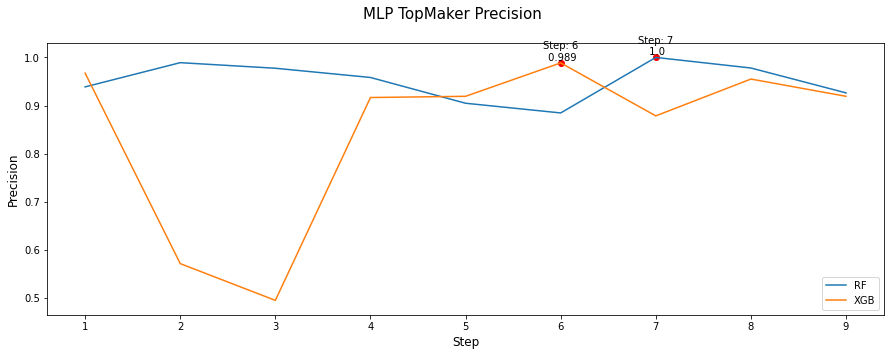

,Step,XGB,RF
0,1,0.967391,0.938776
1,2,0.571429,0.989130
2,3,0.495000,0.977528
3,4,0.916667,0.958333
4,5,0.919192,0.904762
5,6,0.988636,0.884615
6,7,0.878505,1.000000
7,8,0.955056,0.978022
8,9,0.919192,0.926316


In [120]:
score_df = plot_stepwise_accuracy(data, ranking_df, list(np.arange(1,10)), ['MLP', {'max_iter' : 300}], metric = 'Precision')
score_df